In [1]:
#import all the libraries needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import eli5
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve, roc_auc_score
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from eli5.sklearn import PermutationImportance
plt.style.use('dark_background')#because i like dark mode

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


In [2]:
#import the data and set to pets dataframe
pets = pd.read_csv('train.csv',index_col='AnimalID',parse_dates=['DateTime'],skipinitialspace=True)
pets.head()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
AnimalID,,,,,,,,,
A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [3]:
#adjust and sort the colors in the color column to create uniformity
def color_order(c):
    c = re.split(' |/',c)
    c = sorted(c)
    c = ' '.join(c)
    return c

In [4]:
pets[['Color']]= pets['Color'].apply(color_order)
pets.head()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
AnimalID,,,,,,,,,
A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown White
A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue White
A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [5]:
#setup a wrangle function
def wrangle_base(df):
#     pull out the month and year from the date time column
    df['Year']=df['DateTime'].dt.year
    df['Month']=df['DateTime'].dt.month
#     make all the discriptive columns lower case
    df['Name'] = df['Name'].str.lower()
    df['Breed'] = df['Breed'].str.lower()
    df['Color'] = df['Color'].str.lower()
#     create a new column called gender that just specifies male and female
    df['Gender']= df['SexuponOutcome'].apply(lambda x:'female' if x== 'Spayed Female' else(
        'female' if x=='Intact Female' else(
            'male' if x== 'Neutered Male' else(
                'male' if x== 'Intact Male' else(
                    'unknown')))))
#     create a new column called fixed that will just specify fixed or not fixed based on spayed or nutured
    df['Fixed']= df['SexuponOutcome'].apply(lambda x:'fixed' if x== 'Spayed Female' else(
        'not fixed' if x=='Intact Female' else(
            'fixed' if x== 'Neutered Male' else(
                'not fixed' if x== 'Intact Male' else(
                    'unknown')))))
#     split the age upon outcome column so that it can be worked with
    df[['Time1','Time2']] = df['AgeuponOutcome'].str.split(' ',expand=True,)
#     remove the doubled up names in the time 2 column to reduce complexity
    df['Time2']=df['Time2'].replace({'months':'month',
                  'years':'year',
                  'weeks':'week',
                  'days':'day'})
#     convert the time one column into a float so it can be used as a multiplier column
    df['Time1']=df['Time1'].astype(float)
#     create a new age column based on information in the tim one and time 2 column
    df.loc[df['Time2'] == 'year', 'Age'] = df['Time1'] *12
    df.loc[df['Time2'] == 'month', 'Age'] = df['Time1'] *1
    df.loc[df['Time2'] == 'week', 'Age'] = df['Time1'] *0.25
    df.loc[df['Time2'] == 'day', 'Age'] = df['Time1'] *0
    df.loc[df['Time2'] == np.NaN, 'Age'] = np.NaN
#     change multi breed animaled into a mixed breed based on a /
    df['Breed'] = df['Breed'].apply(lambda x:'mixed' if '/' in x else x)

#     replace low value count items with other
    n = df['Name'].value_counts(dropna=False)
    df['Name'] = np.where(df['Name'].isin(n.index[n >= 30]), df['Name'], 'other')
    c = df['Color'].value_counts(dropna=False)
    df['Color'] = np.where(df['Color'].isin(c.index[c >= 20]), df['Color'], 'other')
    b = df['Breed'].value_counts(dropna=False)
    df['Breed'] = np.where(df['Breed'].isin(b.index[b >= 20]), df['Breed'], 'other')
#     drop the columns that are now redunant or replaced with newer columns or are just leaky
    df=df.drop(columns=['SexuponOutcome','DateTime','OutcomeSubtype','AgeuponOutcome','Time1','Time2'])
    return df

pets = wrangle_base(pets)
pets.head(10)

,Name,OutcomeType,AnimalType,Breed,Color,Year,Month,Gender,Fixed,Age
AnimalID,,,,,,,,,,
A671945,other,Return_to_owner,Dog,shetland sheepdog mix,brown white,2014,2,male,fixed,12.00
A656520,other,Euthanasia,Cat,domestic shorthair mix,cream tabby,2013,10,female,fixed,12.00
A686464,other,Adoption,Dog,pit bull mix,blue white,2015,1,male,fixed,24.00
A683430,NaN,Transfer,Cat,domestic shorthair mix,other,2014,7,male,not fixed,0.75
A667013,NaN,Transfer,Dog,mixed,tan,2013,11,male,fixed,24.00
A677334,other,Transfer,Dog,mixed,black tan,2014,4,female,not fixed,1.00
A699218,other,Transfer,Cat,domestic shorthair mix,blue tabby,2015,3,male,not fixed,0.75
A701489,NaN,Transfer,Cat,domestic shorthair mix,brown tabby,2015,4,unknown,unknown,0.75
A671784,lucy,Adoption,Dog,american pit bull terrier mix,red white,2014,2,female,fixed,5.00


In [6]:
#determine how many unique values each column has to see if it needs to be eliminated
print('Color=',pets['Color'].value_counts().nunique())
print('Animal Type=',pets['AnimalType'].value_counts().nunique())
print('Breed=',pets['Breed'].value_counts().nunique())
print('Name=',pets['Name'].value_counts().nunique())

Color= 72
Animal Type= 2
Breed= 68
Name= 39


In [7]:
colors_df = pd.DataFrame(pets['Color'].value_counts(dropna=False))
colors_df.reset_index(level=0, inplace=True)
colors_df.columns =['Color','Quant']
colors_df.drop(columns='Quant',inplace=True)
colors_df.to_csv('Colors.csv',index=True)

In [8]:
#target column Binary version
print(pets['OutcomeType'].value_counts(normalize=True))
y_binary = pets['OutcomeType'].apply(lambda x:1 if x=='Adoption' else(1 if x=='Return_to_owner' else 0))
X_binary = pets.drop(['OutcomeType'],axis=1)
print(y_binary.shape)
print(X_binary.head())

Adoption           0.402896
Transfer           0.352501
Return_to_owner    0.179056
Euthanasia         0.058177
Died               0.007370
Name: OutcomeType, dtype: float64
(26729,)
           Name AnimalType                   Breed        Color  Year  Month  \
AnimalID                                                                       
A671945   other        Dog   shetland sheepdog mix  brown white  2014      2   
A656520   other        Cat  domestic shorthair mix  cream tabby  2013     10   
A686464   other        Dog            pit bull mix   blue white  2015      1   
A683430     NaN        Cat  domestic shorthair mix        other  2014      7   
A667013     NaN        Dog                   mixed          tan  2013     11   

          Gender      Fixed    Age  
AnimalID                            
A671945     male      fixed  12.00  
A656520   female      fixed  12.00  
A686464     male      fixed  24.00  
A683430     male  not fixed   0.75  
A667013     male      fixed  24.00

In [9]:
# Train-val split Binary ordinal
X_train, X_val, y_train, y_val = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42)

In [10]:
print('Baseline accuracy:', y_train.value_counts(normalize=True).max())

Baseline accuracy: 0.5787307674320722


In [11]:
ord_encod=make_pipeline(
    OrdinalEncoder(),
    SimpleImputer()
)

X_train_ord=pd.DataFrame(ord_encod.fit_transform(X_train),columns=X_train.columns.tolist())
X_val_ord=pd.DataFrame(ord_encod.fit_transform(X_val),columns=X_train.columns.tolist())

### Logistic regression pipepline Ordinal and results

In [12]:
log_mod = LogisticRegression()

In [13]:
log_mod.fit(X_train_ord,y_train)

LogisticRegression()

In [14]:
y_pred_log_ord=log_mod.score(X_val_ord,y_val)

In [15]:
print(y_pred_log_ord)

0.8028432472876917


### PDP for Logistic regresor

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <AxesSubplot:>,
  'pdp_inter_ax': <AxesSubplot:xlabel='Name', ylabel='Age'>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


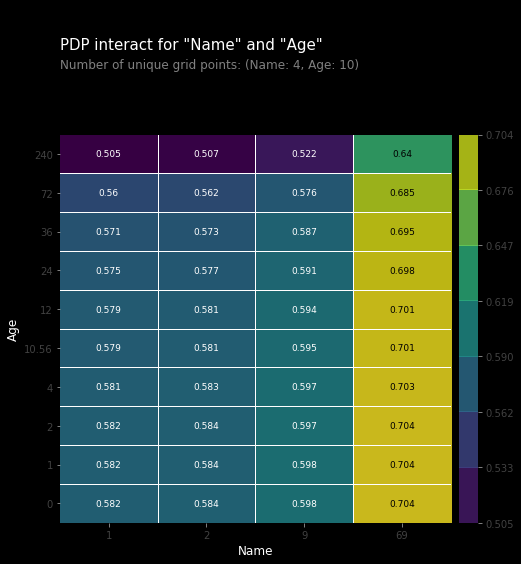

In [16]:
log_feat=['Name','Age']
log_inter = pdp_interact(
    model = log_mod,
    dataset=X_val_ord,
    model_features=X_val.columns,
    features=log_feat
)
pdp_interact_plot(log_inter,feature_names=log_feat,plot_type='grid')

### Random forest pipeline and Results

In [17]:
rand_mod_ord=make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier())
rand_mod_ord.fit(X_train,y_train)


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Name', 'AnimalType', 'Breed', 'Color',
                                      'Gender', 'Fixed'],
                                mapping=[{'col': 'Name',
                                          'data_type': dtype('O'),
                                          'mapping': other       1
NaN         2
buddy       3
marley      4
daisy       5
           ..
lucky      65
jasmine    66
bear       67
rex        68
jasper     69
Length: 69, dtype: int64},
                                         {'col': 'AnimalType',
                                          'data_type': dtype('O'),
                                          'mapping': Cat    1
Dog    2
NaN   -2
dtype: int64},
                                         {'col': 'Breed',
                                          'd...
black white        5
                  ..
blue merle tan    83
blue point        84
white yellow      85
red tan           86
NaN           

In [18]:
y_pred_rf_ord=rand_mod_ord.score(X_val,y_val)
print(y_pred_rf_ord)

0.7977927422371867


### Random Forest Tunning

In [26]:
params = {
    'randomforestclassifier__n_estimators': range(25,301,5),
    'randomforestclassifier__max_depth': range(5,26,1)
}

rf_grid = GridSearchCV(
    rand_mod_ord,
    param_grid = params,
    cv=10,
    n_jobs=-1,
    verbose=5
)
rf_grid.fit(X_train,y_train)

Fitting 10 folds for each of 1176 candidates, totalling 11760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 1104 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1410 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2130 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2544 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2994 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3480 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 4560 tasks      | e

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ordinalencoder',
                                        OrdinalEncoder(cols=['Name',
                                                             'AnimalType',
                                                             'Breed', 'Color',
                                                             'Gender',
                                                             'Fixed'],
                                                       mapping=[{'col': 'Name',
                                                                 'data_type': dtype('O'),
                                                                 'mapping': other       1
NaN         2
buddy       3
marley      4
daisy       5
           ..
lucky      65
jasmine    66
bear       67
rex        68
jasper     69
Length: 69, dtype: int64},
                                                                {'col': 'AnimalType',
                                            

In [27]:
print(rf_grid.best_score_)
print(rf_grid.best_params_)

0.8164427088184988
{'randomforestclassifier__max_depth': 11, 'randomforestclassifier__n_estimators': 80}


### Shaply on Random forest

In [19]:
rand_mod_ords = RandomForestClassifier()
rand_mod_ords.fit(X_train_ord,y_train)
row=X_val_ord.iloc[[3]]
row

,Name,AnimalType,Breed,Color,Year,Month,Gender,Fixed,Age
3,1.0,2.0,55.0,21.0,2014.0,11.0,2.0,1.0,60.0


In [20]:
rand_score=rand_mod_ords.predict(row)
rand_score

array([1])

In [21]:
exp=shap.TreeExplainer(rand_mod_ords)
shap_values=exp.shap_values(row)
shap.initjs()
shap.force_plot(
    base_value=exp.expected_value[1],
    shap_values=shap_values[1],
    features=row
)

### GB Classifier

In [22]:
gbc_mod_ord = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    GradientBoostingClassifier(random_state=42,))
gbc_mod_ord.fit(X_train,y_train)
gbc_mod_ord.score(X_val,y_val)

0.8116348671904228

### GBC Tunning

In [23]:
params = {
    'gradientboostingclassifier__n_estimators': range(25,501,5),
}

gbc_grid = GridSearchCV(
    gbc_mod_ord,
    param_grid = params,
    cv=10,
    n_jobs=-1,
    verbose=5
)
gbc_grid.fit(X_train,y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  2.4min finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ordinalencoder',
                                        OrdinalEncoder(cols=['Name',
                                                             'AnimalType',
                                                             'Breed', 'Color',
                                                             'Gender',
                                                             'Fixed'],
                                                       mapping=[{'col': 'Name',
                                                                 'data_type': dtype('O'),
                                                                 'mapping': other       1
NaN         2
buddy       3
marley      4
daisy       5
           ..
lucky      65
jasmine    66
bear       67
rex        68
jasper     69
Length: 69, dtype: int64},
                                                                {'col': 'AnimalType',
                                            

In [24]:
print(gbc_grid.best_score_)
print(gbc_grid.best_params_)

0.8138706484893887
{'gradientboostingclassifier__n_estimators': 330}


### PDP Graphs

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


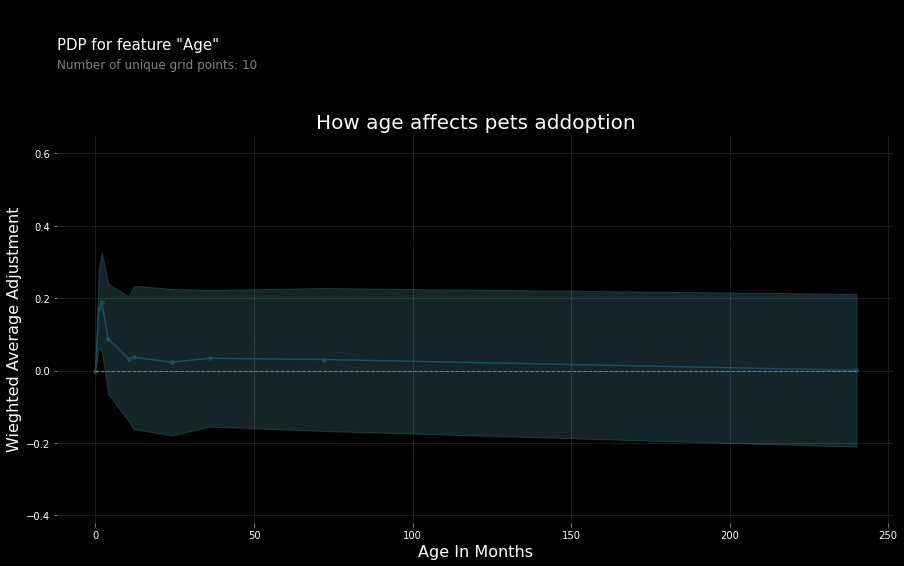

In [28]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Age'

isolate = pdp_isolate(
    model=rand_mod_ords,
    dataset=X_val_ord, # <-- use validation data
    model_features=X_val_ord.columns,
    feature=feature
)

pdp_plot(isolate, feature_name=feature)
plt.xlabel('Age In Months', fontsize=16)
plt.ylabel('Wieghted Average Adjustment', fontsize=16)
plt.title('How age affects pets addoption', fontsize=20)
plt.xticks(color='white')
plt.yticks(color='white')
plt.grid(color='white')
plt.savefig('AgePDP.png')
plt.show()


### Feature Importance Graph

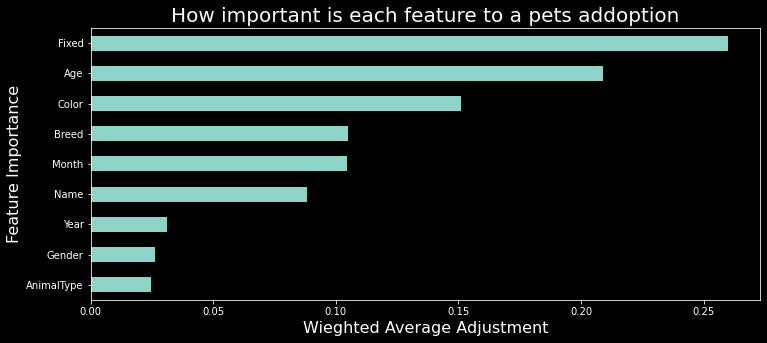

In [29]:
imp = rand_mod_ord.named_steps['randomforestclassifier'].feature_importances_
fig_fi, ax2 = plt.subplots(figsize=(12,5))
fi = pd.Series(imp, index=X_train_ord.columns).sort_values()
fi.plot(kind='barh')
ax2.set_ylabel('Feature Importance', fontsize=16)
ax2.set_xlabel('Wieghted Average Adjustment', fontsize=16)
plt.title('How important is each feature to a pets addoption', fontsize=20)
plt.savefig('FeaturesRF.png')
plt.show()

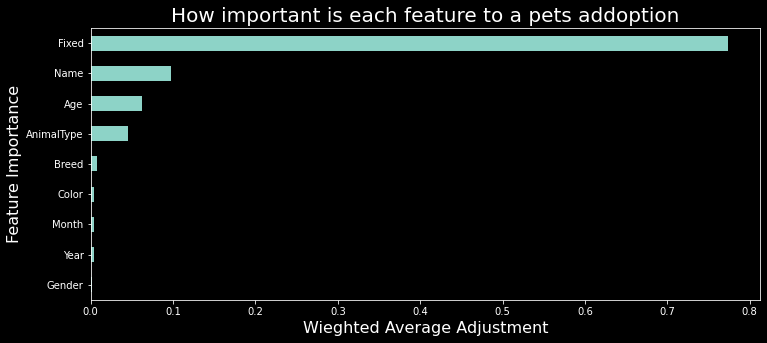

In [30]:
imp = gbc_mod_ord.named_steps['gradientboostingclassifier'].feature_importances_
fig_fi, ax2 = plt.subplots(figsize=(12,5))
fi = pd.Series(imp, index=X_train_ord.columns).sort_values()
fi.plot(kind='barh')
ax2.set_ylabel('Feature Importance', fontsize=16)
ax2.set_xlabel('Wieghted Average Adjustment', fontsize=16)
plt.title('How important is each feature to a pets addoption', fontsize=20)
plt.savefig('FeaturesGBC.png')
plt.show()

### ROC CurveGraphs

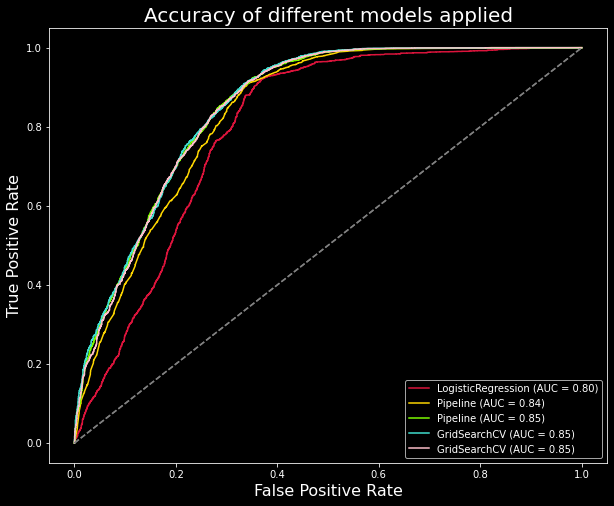

In [31]:
fig_roc, ax3 = plt.subplots(figsize=(10,8))
lr = plot_roc_curve(log_mod, X_val_ord, y_val, ax=ax3, color='crimson')
rf = plot_roc_curve(rand_mod_ord, X_val, y_val, ax=ax3, color='gold')
gbc = plot_roc_curve(gbc_mod_ord, X_val, y_val, ax=ax3, color='lawngreen')
rf_tune = plot_roc_curve(rf_grid, X_val, y_val, ax=ax3, color='turquoise')
gbc_tune = plot_roc_curve(gbc_grid, X_val, y_val, ax=ax3, color='pink')
ax3.plot([(0,0), (1,1)], color='grey', linestyle='--')
plt.title('Accuracy of different models applied',fontsize=20)
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
plt.savefig('ROCcurve.png')
plt.show()

### Pickling my Tuned Randome Forest model for use in web app

In [32]:
from joblib import dump
dump(rf_grid, 'pipeline.joblib', compress=True)

['pipeline.joblib']